In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
import seaborn as sns
import ternary
from toolbox import hillshade
%matplotlib inline

In [2]:
# Set directory
os.chdir('/media/silva/Disc/Research/DADOS_TF_SENS_REMOTO')

In [3]:
def plot_corr(dataframe, size=10):
    plt.figure(figsize = (size+size*0.2, size), facecolor='w')
    corrMatrix = dataframe.corr()
    sns.heatmap(np.round(corrMatrix,2), annot=True)
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0, ha='right')

In [4]:
def compute_pca(df, variables, explained_variance='on'):
    
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    X = df.loc[:, variables].values
    mu_ = np.mean(X, axis=0)
    sd_ = np.std(X, axis=0)
    scaler = StandardScaler()
    x = scaler.fit_transform(X)
    
    n_components = len(variables)
    pca = PCA(n_components=n_components, whiten=True)
    pca.fit(x)
    
    n_pcs = np.arange(1, len(variables)+1)
    pc = ['PC']*(len(variables) + 1)

    PCs = []
    for i, k in zip(pc, n_pcs):
        PCs.append(i+str(k))
        
    PC_transformed = []
    for i in range(len(variables)):
        pc_dot = np.dot(pca.transform(x)[:,:i+1], pca.components_[:i+1,:])
        pc_dot_ = sd_*pc_dot + mu_
        PC_transformed.append(pc_dot_)
    
    pcs = np.array(PC_transformed)
        
    fig, ax=plt.subplots(figsize=(len(variables), len(variables)))
    im=ax.matshow(pca.components_,cmap='plasma')
    for (i, j), z in np.ndenumerate(pca.components_):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    fig.colorbar(im, label='Eigenvalues')
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(10, 8)
    plt.yticks(range(len(variables)), PCs,fontsize=9)
    plt.xticks(range(len(variables)), variables,rotation=55,fontsize = 10, ha='left')
    plt.tight_layout()
    plt.show()
    
    if explained_variance == 'on':
        plt.figure(figsize=(8, 4), facecolor='w')
        plt.bar(PCs,pca.explained_variance_ratio_ *100, color='orangered')
        plt.xticks(rotation = 90)
        plt.ylabel('Variance explained by component (%)')
        plt.grid(which='both', linewidth=0.4)
    
    return pcs

### Importing XYZ remote sensing dataset

In [5]:
df_rs = pd.read_csv('df_remote_sensing.xyz')
df_rs.head()

E_utm      N_utm  GREEN  RED  NIR  SWIR1  SWIR2_1  SWIR2_2  \
0  262575.000000  8113097.5      0    0    0      0        0        0   
1  262620.038560  8113097.5     87   87   75     99       74       81   
2  262665.077121  8113097.5    104  116   92     94       72       76   
3  262710.115681  8113097.5     87   92   76     88       67       72   
4  262755.154242  8113097.5     80   84   72     85       65       70   

   SWIR2_3  SWIR2_4  ...  TIR4  TIR5  DEM  OLI_RED  OLI_NIR      Slope  \
0        0        0  ...  1926  1997    0     9262    15774  86.616355   
1       72       69  ...  1926  1997    0     9779    15585  86.620780   
2       70       67  ...  1907  1983    0    10158    15930  86.620780   
3       64       64  ...  1907  1983    0    12710    18008  86.633984   
4       62       63  ...  1903  1974    0    12379    17523  86.625192   

   ASTER_RED_1984  ASTER_NIR_1984  ASTER_RED_1986  ASTER_NIR_1986  
0               0               0           10217           16005  
1               0               0           10850           16468  
2              34              52           11733           16931  
3              35              54           11481           16159  
4              39              56           11355           15387  

[5 rows x 24 columns]

In [6]:
df_rs.describe()

E_utm         N_utm         GREEN           RED           NIR  \
count  1.326848e+06  1.326848e+06  1.326848e+06  1.326848e+06  1.326848e+06   
mean   2.888550e+05  8.138665e+06  7.101722e+01  6.433084e+01  6.889133e+01   
std    1.518577e+04  1.477441e+04  1.329552e+01  1.999514e+01  1.005144e+01   
min    2.625750e+05  8.113098e+06  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.757150e+05  8.125881e+06  6.100000e+01  4.900000e+01  6.200000e+01   
50%    2.888550e+05  8.138665e+06  6.700000e+01  5.900000e+01  6.900000e+01   
75%    3.019950e+05  8.151449e+06  8.000000e+01  7.900000e+01  7.500000e+01   
max    3.151350e+05  8.164232e+06  1.820000e+02  1.830000e+02  1.300000e+02   

              SWIR1       SWIR2_1       SWIR2_2       SWIR2_3       SWIR2_4  \
count  1.326848e+06  1.326848e+06  1.326848e+06  1.326848e+06  1.326848e+06   
mean   7.738332e+01  5.459909e+01  5.783296e+01  5.072582e+01  4.782361e+01   
std    1.559295e+01  1.223862e+01  1.400266e+01  1.263550e+01  1.255020e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    6.500000e+01  4.500000e+01  4.700000e+01  4.100000e+01  3.800000e+01   
50%    7.500000e+01  5.300000e+01  5.600000e+01  4.900000e+01  4.600000e+01   
75%    9.000000e+01  6.400000e+01  6.900000e+01  6.000000e+01  5.700000e+01   
max    1.500000e+02  1.090000e+02  2.140000e+02  1.880000e+02  1.140000e+02   

       ...          TIR4          TIR5           DEM       OLI_RED  \
count  ...  1.326848e+06  1.326848e+06  1.326848e+06  1.326848e+06   
mean   ...  1.863251e+03  1.932565e+03  5.356137e+02  9.565707e+03   
std    ...  6.839489e+01  6.267457e+01  9.458438e+01  1.274394e+03   
min    ...  1.616000e+03  1.714000e+03  0.000000e+00  7.327000e+03   
25%    ...  1.812000e+03  1.886000e+03  4.750000e+02  8.481000e+03   
50%    ...  1.858000e+03  1.928000e+03  5.080000e+02  9.305000e+03   
75%    ...  1.911000e+03  1.977000e+03  5.610000e+02  1.043100e+04   
max    ...  2.189000e+03  2.236000e+03  8.750000e+02  2.206400e+04   

            OLI_NIR         Slope  ASTER_RED_1984  ASTER_NIR_1984  \
count  1.326848e+06  1.326848e+06    1.326848e+06    1.326848e+06   
mean   1.673933e+04  4.987282e+00    2.531161e+01    5.678141e+01   
std    1.447045e+03  4.840171e+00    6.053424e+00    8.058317e+00   
min    6.839000e+03  0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.585400e+04  2.562377e+00    2.200000e+01    5.200000e+01   
50%    1.664700e+04  4.046740e+00    2.400000e+01    5.600000e+01   
75%    1.752800e+04  6.031429e+00    2.800000e+01    6.000000e+01   
max    2.879900e+04  8.700466e+01    1.160000e+02    1.940000e+02   

       ASTER_RED_1986  ASTER_NIR_1986  
count    1.326848e+06    1.326848e+06  
mean     9.361104e+03    1.664472e+04  
std      8.735033e+02    1.528637e+03  
min      6.370000e+03    8.675000e+03  
25%      8.849000e+03    1.571300e+04  
50%      9.158000e+03    1.639300e+04  
75%      9.579000e+03    1.740000e+04  
max      2.628100e+04    4.018700e+04  

[8 rows x 24 columns]

#### Computing NDVI

In [7]:
# Ndvi - 1984
NDVI = np.array(((df_rs.ASTER_NIR_1984 - df_rs.ASTER_RED_1984) + 1)/((df_rs.ASTER_NIR_1984 + df_rs.ASTER_RED_1984) + 1))
df_rs['NDVI_1984'] = (NDVI - NDVI.mean())/NDVI.std()

# Ndvi - 1986
NDVI = np.array(((df_rs.ASTER_NIR_1986 - df_rs.ASTER_RED_1986) + 1)/((df_rs.ASTER_NIR_1986 + df_rs.ASTER_RED_1986) + 1))
df_rs['NDVI_1986'] = (NDVI - NDVI.mean())/NDVI.std()

# Ndvi - 2004-2005
NDVI = np.array(((df_rs.NIR - df_rs.RED) + 1)/((df_rs.NIR + df_rs.RED) + 1))
df_rs['NDVI_2004'] = (NDVI - NDVI.mean())/NDVI.std()
# Ndvi - 2021
NDVI = np.array(((df_rs.OLI_NIR - df_rs.OLI_RED) + 1)/((df_rs.OLI_NIR + df_rs.OLI_RED) + 1))
df_rs['NDVI_2021'] = (NDVI - NDVI.mean())/NDVI.std()

### Pixel size

In [8]:
xpixel_size = (df_rs.E_utm.max()-df_rs.E_utm.min())/df_rs.E_utm.unique().size
ypixel_size = (df_rs.N_utm.max()-df_rs.N_utm.min())/df_rs.N_utm.unique().size
print('x:', xpixel_size, 'y:', ypixel_size)

x: 45.0 y: 45.01320422535211


In [9]:
nx=df_rs.E_utm.unique().size
ny=df_rs.N_utm.unique().size
ratio=ny/nx
xs = df_rs.E_utm.values.reshape(ny, nx)
ys = df_rs.N_utm.values.reshape(ny, nx)

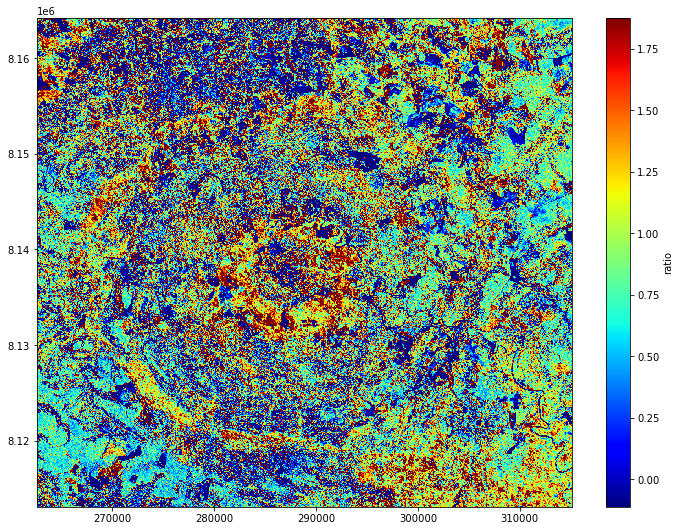

In [10]:
var = np.array((df_rs['NDVI_1986']. values+1)/(df_rs['NDVI_1984'].values+1)).reshape(ny, nx)
plt.figure(figsize=(12, int(ratio * 10)))
plt.pcolormesh(xs, ys, var, cmap='jet', shading='auto', vmin=np.percentile(var, 15), vmax=np.percentile(var, 85))
plt.colorbar(label='ratio')

In [11]:
features = list(df_rs.columns[2:])
print(features)

['GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2_1', 'SWIR2_2', 'SWIR2_3', 'SWIR2_4', 'SWIR2_5', 'TIR1', 'TIR2', 'TIR3', 'TIR4', 'TIR5', 'DEM', 'OLI_RED', 'OLI_NIR', 'Slope', 'ASTER_RED_1984', 'ASTER_NIR_1984', 'ASTER_RED_1986', 'ASTER_NIR_1986', 'NDVI_1984', 'NDVI_1986', 'NDVI_2004', 'NDVI_2021']


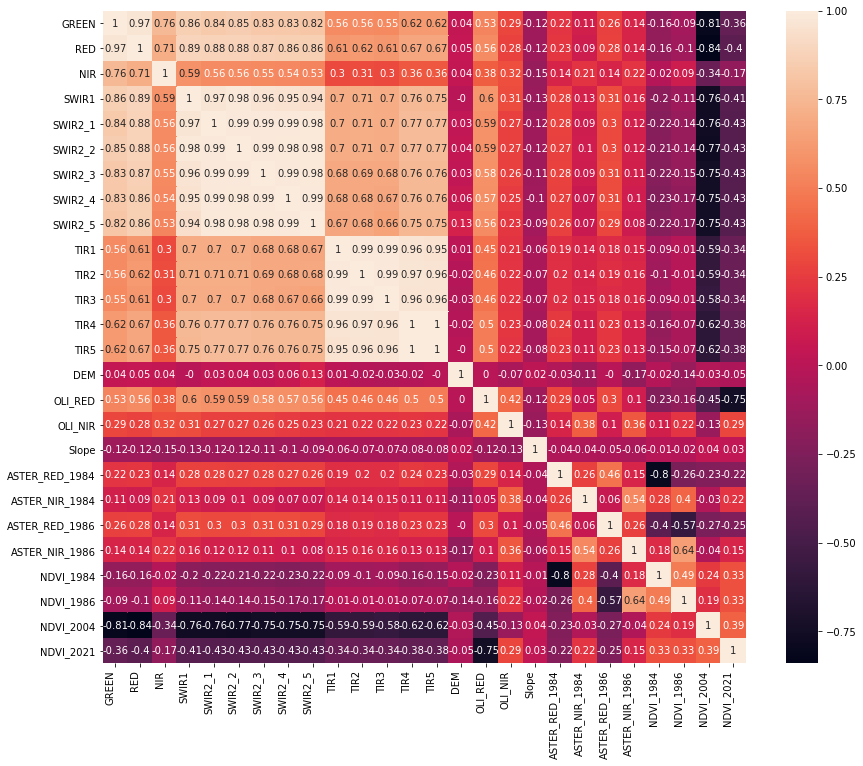

In [12]:
plot_corr(df_rs[features], size=12)
plt.savefig('figs/correlation_matrix.png', dpi=400, bbox_inches='tight')

### PCA

In [13]:
features = ['GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2_1', 'SWIR2_2', 'SWIR2_3',
            'SWIR2_4', 'SWIR2_5', 'TIR1', 'TIR2', 'TIR3', 'DEM', 'Slope', 
            'NDVI_1984', 'NDVI_1986', 'NDVI_2004', 'NDVI_2021']

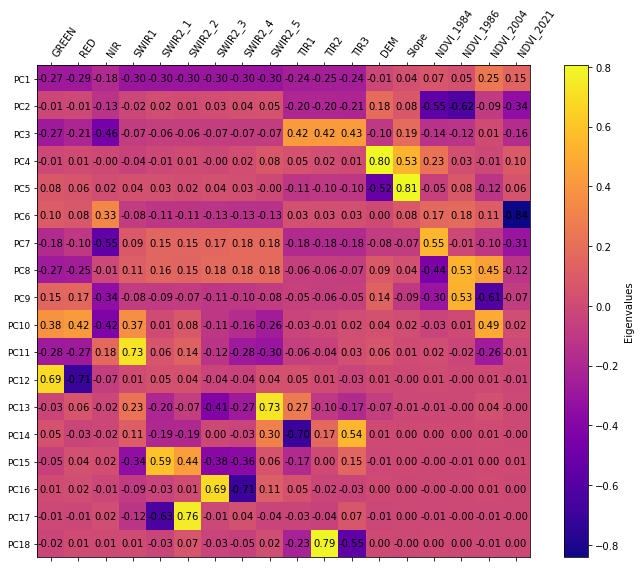

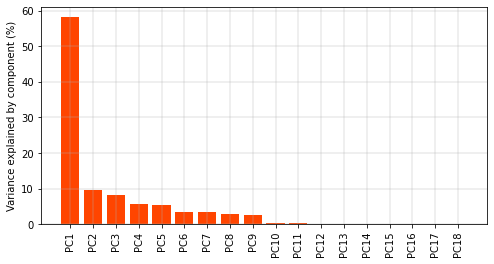

In [14]:
pcs = compute_pca(df_rs, features, explained_variance='on')
plt.savefig('figs/eigenvalues_matrix.png', dpi=400, bbox_inches='tight')

In [15]:
def pcs_dataframe(pcs, x, y, n_pcs=pcs.shape[0]):
    
    data = {'X':x, 'Y':y}
    
    components = np.arange(1, n_pcs+1)
    pc = ['PC']*(len(components)+1)

    PCs = []
    for i, k in zip(pc, components):
        PCs.append(i+str(k))

    for n in range(n_pcs):
        data[PCs[n]] = pcs[n][:,0]

    df = pd.DataFrame(data)

    return df

In [16]:
pcs_df=pcs_dataframe(pcs, df_rs.E_utm, df_rs.N_utm)
pcs_df.head(3)

X          Y        PC1        PC2        PC3        PC4  \
0  262575.000000  8113097.5  55.254706  55.641920  23.061713  22.656342   
1  262620.038560  8113097.5  75.048000  75.329925  68.205414  67.767285   
2  262665.077121  8113097.5  76.209221  75.843094  70.742112  70.443760   

         PC5        PC6        PC7         PC8        PC9       PC10  \
0  37.420117  42.795627  34.246813   42.867666  24.095605  88.940988   
1  85.670619  88.997485  77.577393   91.581885  76.089138  68.068050   
2  89.150157  91.717736  97.658699  100.372418  92.233029  94.238585   

         PC11       PC12       PC13       PC14       PC15       PC16  \
0  128.864992  62.307686  62.766840  61.134855  61.751722  61.701015   
1   74.012371  84.656912  82.519328  83.179247  82.705720  82.821302   
2  110.489530  97.749070  95.905586  95.966208  95.344446  95.474801   

        PC17       PC18  
0  61.344857  60.663359  
1  82.717717  82.122656  
2  95.467941  94.969458

In [17]:
pcs_df.to_csv('RS_PCs.xyz', sep=',', index_label=False, index=False)

## Ternary plots

In [18]:
# defining arguments
variables_rgb = ['PC1', 'PC2', 'PC3'] # a list with the name of the variables in the RGB order;

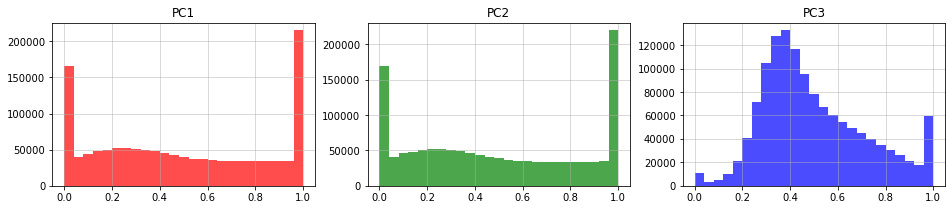

In [19]:
RGB, extent = ternary.grid(pcs_df, variables_rgb, 'X', 'Y', center=0.5, stretch=0.6)

# the first output consists of the grid (M,N 3) used to create the RGB image.
# the second output consists of the extent (coordinates) of the espacial data we intend to plot.

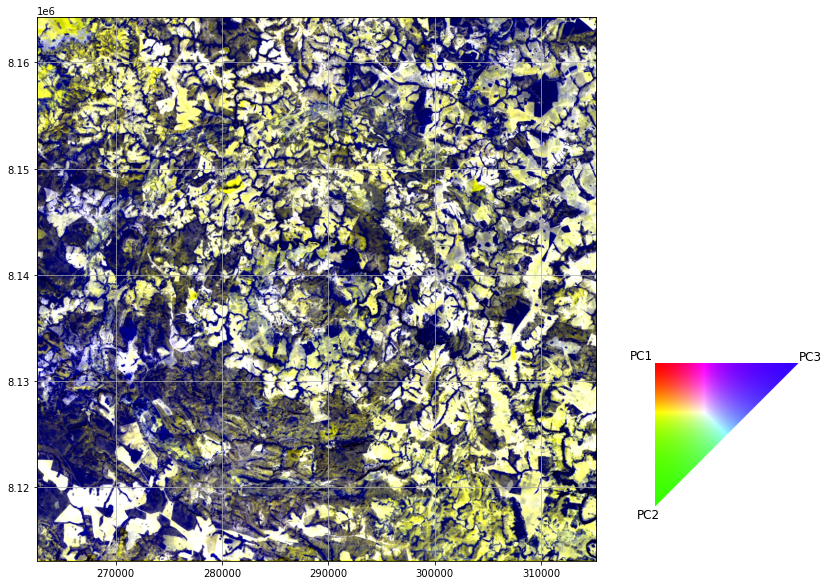

In [20]:
ax = ternary.plot(RGB, variables_rgb, extent, triangle_position=[0.82, 0.2, 0.2, 0.2])
ax.grid(linewidth=0.9, alpha=0.8)
plt.savefig(f'figs/pca_ternary_{variables_rgb[0]+variables_rgb[1]+variables_rgb[2]}.png',
            dpi=400, bbox_inches='tight')

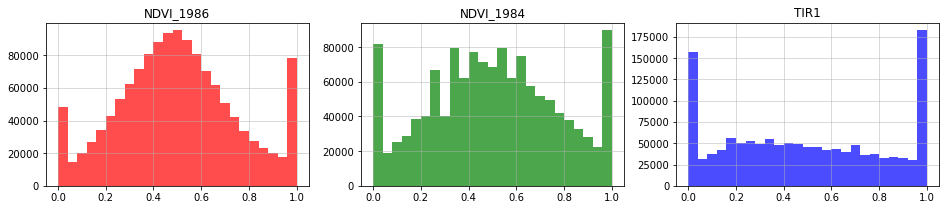

In [21]:
# defining arguments
# a list with the name of the variables in the RGB order;
variables_rgb = ['NDVI_1986', 'NDVI_1984', 'TIR1'] 

RGB, extent = ternary.grid(df_rs, variables_rgb, 'E_utm', 'N_utm', center=0.5, stretch=.5)

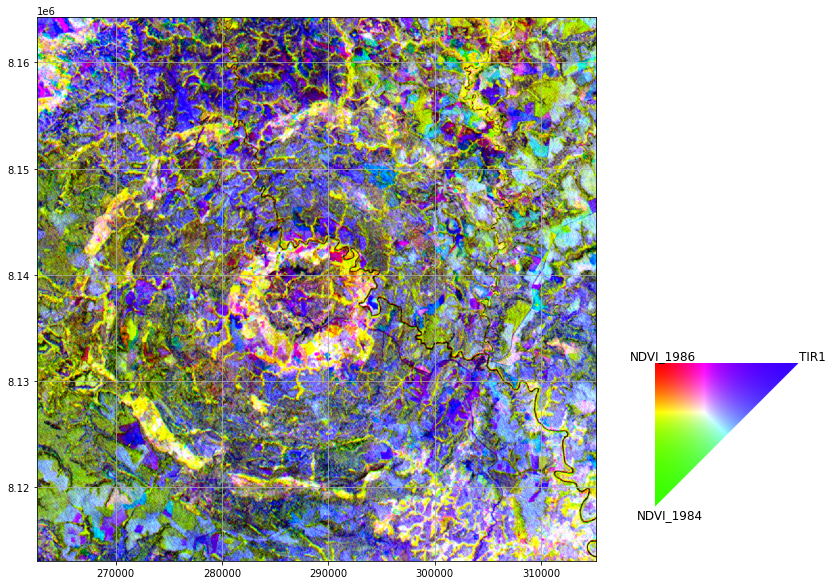

In [22]:
# the first output consists of the grid (M,N 3) used to create the RGB image.
# the second output consists of the extent (coordinates) of the espacial data we intend to plot.

ax = ternary.plot(RGB, variables_rgb, extent, triangle_position=[0.82, 0.2, 0.2, 0.2])
ax.grid(linewidth=0.9, alpha=0.8)

### Self-organizing maps (SOM)

In [23]:
from sklearn_som.som import SOM

In [24]:
features = ['GREEN', 'DEM', 'SWIR1', 'NDVI_1984', 'NDVI_1986']
print(features)

['GREEN', 'DEM', 'SWIR1', 'NDVI_1984', 'NDVI_1986']


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(df_rs[features].values)
# data = df_rs[features].values

In [26]:
n_clusters=5
lito_SOM = SOM(m=n_clusters, n=1, sigma=1.25, dim=len(features), max_iter=6000)
lito_SOM.fit(data)

In [27]:
# predição de classes
predictions = lito_SOM.predict(data)

In [28]:
# create labels
cluster_labels=[]
for i in range(n_clusters):
    cluster_labels+=[f'Classe {i+1}']

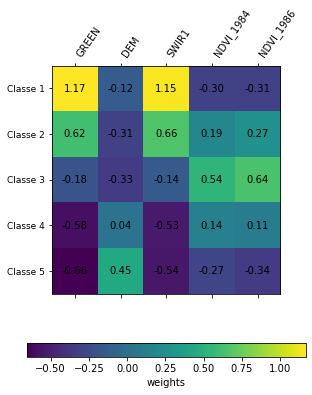

In [29]:
# classes weights
fig, ax = plt.subplots()
im=ax.matshow(lito_SOM.weights)
for (i, j), z in np.ndenumerate(lito_SOM.weights):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

plt.yticks(range(n_clusters), cluster_labels, fontsize=9)
plt.xticks(range(len(features)), features, rotation=55, fontsize=10, ha='left')
fig.colorbar(im, label='weights', orientation='horizontal')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(5, 6)
plt.show()

In [30]:
import matplotlib
id_ = [4, 3, 11, 5, 6]
relcolor =  matplotlib.cm.Set3
colors = np.array(relcolor.colors)[id_]
relcolor = matplotlib.colors.ListedColormap(colors)

In [31]:
idxs=np.arange(0, n_clusters, 1)
half=(idxs[1]-idxs[0])/2
ticks=np.linspace(idxs[0]+half, idxs[-1]-half, n_clusters)

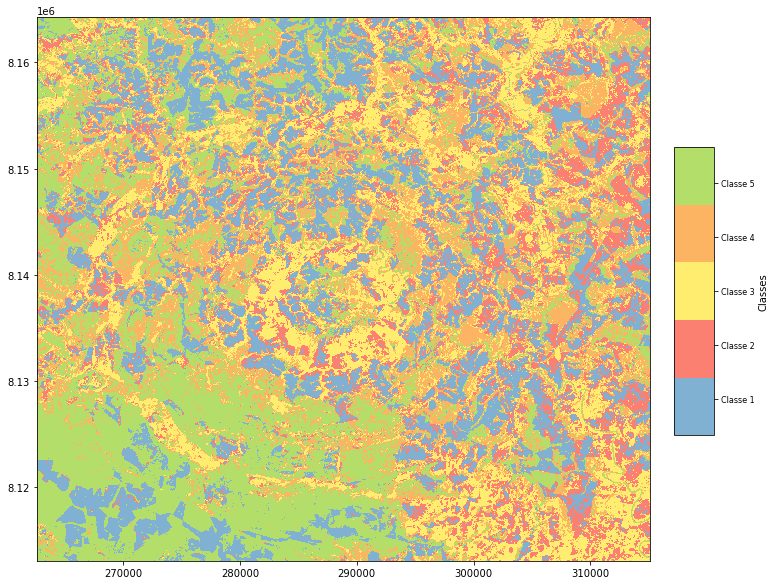

In [32]:
fig, ax=plt.subplots(figsize=(11, int(ratio*11)), facecolor='w')
im=plt.pcolormesh(xs, ys, predictions.reshape(ny, nx), cmap=relcolor, shading='auto')
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels, fontsize=8)
plt.show()

### Hillshade

In [33]:
hillshd = hillshade(df_rs['DEM'].values.reshape(ny, nx), 330, 15)

[Text(1, 0.5, 'Classe 1'),
 Text(1, 1.25, 'Classe 2'),
 Text(1, 2.0, 'Classe 3'),
 Text(1, 2.75, 'Classe 4'),
 Text(1, 3.5, 'Classe 5')]

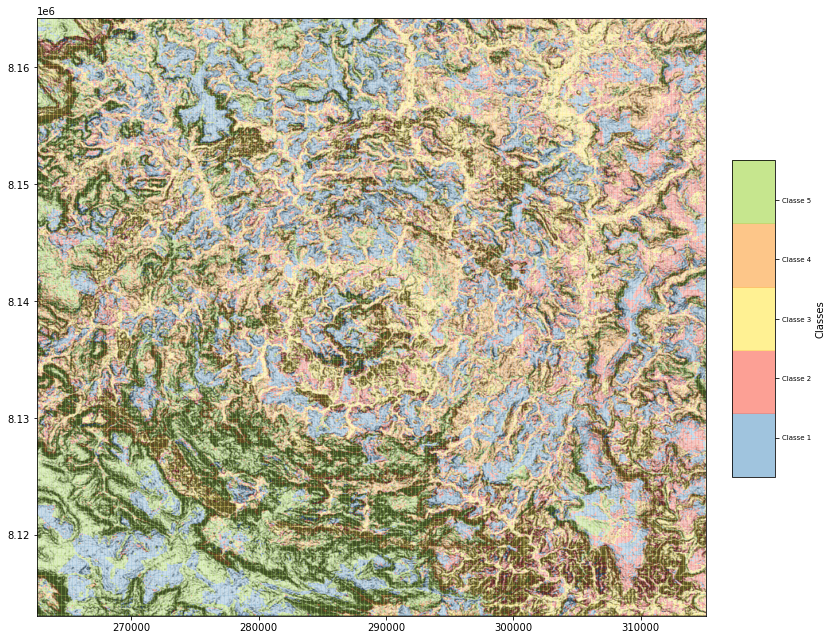

In [34]:
fig, ax=plt.subplots(figsize=(12, int(ratio*12)), facecolor='w')
slope = df_rs.Slope.values.reshape(ny, nx)
backg = ax.pcolormesh(xs, ys, hillshd, vmin=np.percentile(hillshd, 15), vmax=np.percentile(hillshd, 85),
                      shading='auto', cmap = 'Greys', alpha=1.0)
im=plt.pcolormesh(xs, ys, predictions.reshape(ny,nx), cmap=relcolor, shading='auto', alpha=0.75)

front = ax.pcolormesh(xs, ys, slope, vmin=np.percentile(slope, 15), vmax=np.percentile(slope, 85),
                      shading='auto', cmap = 'Greys', alpha=0.1)
plt.xlim(xs.min(), xs.max())
plt.ylim(ys.min(), ys.max())
cbar_ax = fig.add_axes([0.93, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax, label = u'Classes', orientation='vertical',
                    ticks=ticks)
cbar.ax.set_yticklabels(cluster_labels,fontsize=7)